In [ ]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16 , preprocess_input
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input , Dense , LSTM , Embedding , Dropout , add

In [ ]:
data_dir = '/content/flickr8k'
output_dir = '/content/working/'

In [ ]:
vgg16 = VGG16()

242900224/242900224 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
91884032/91884032 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
vgg16.layers

[<InputLayer name=input_layer_3, built=True>,
 <Conv2D name=block1_conv1, built=True>,
 <BatchNormalization name=block1_conv1_bn, built=True>,
 <Activation name=block1_conv1_act, built=True>,
 <Conv2D name=block1_conv2, built=True>,
 <BatchNormalization name=block1_conv2_bn, built=True>,
 <Activation name=block1_conv2_act, built=True>,
 <SeparableConv2D name=block2_sepconv1, built=True>,
 <BatchNormalization name=block2_sepconv1_bn, built=True>,
 <Activation name=block2_sepconv2_act, built=True>,
 <SeparableConv2D name=block2_sepconv2, built=True>,
 <BatchNormalization name=block2_sepconv2_bn, built=True>,
 <Conv2D name=conv2d, built=True>,
 <MaxPooling2D name=block2_pool, built=True>,
 <BatchNormalization name=batch_normalization, built=True>,
 <Add name=add, built=True>,
 <Activation name=block3_sepconv1_act, built=True>,
 <SeparableConv2D name=block3_sepconv1, built=True>,
 <BatchNormalization name=block3_sepconv1_bn, built=True>,
 <Activation name=block3_sepconv2_act, built=True>,


In [ ]:
model = Model(inputs = vgg16.inputs, outputs = vgg16.layers[-2].output)
model.summary()

ValueError: Unrecognized keyword arguments passed to Model: {'inputs': <Functional name=xception, built=True>, 'opuputs': <KerasTensor shape=(None, 1000), dtype=float32, sparse=False, name=keras_tensor_696>}

In [ ]:
features = {}
directory = os.path.join(data_dir, 'Images')
for img_name in tqdm(os.listdir(directory)):
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
pickle.dump(features, open(os.path.join(output_dir, 'features.pkl'), 'wb'))

In [ ]:
with open(os.path.join(data_dir, 'captions.txt'), 'r') as file:
    next(file)
    captions_doc = file.read()

In [ ]:
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

In [ ]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [ ]:
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
clean(mapping)


In [ ]:
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

# Preprocessing the text data

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
vocab_size

8485

In [ ]:

max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [ ]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [ ]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):

    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

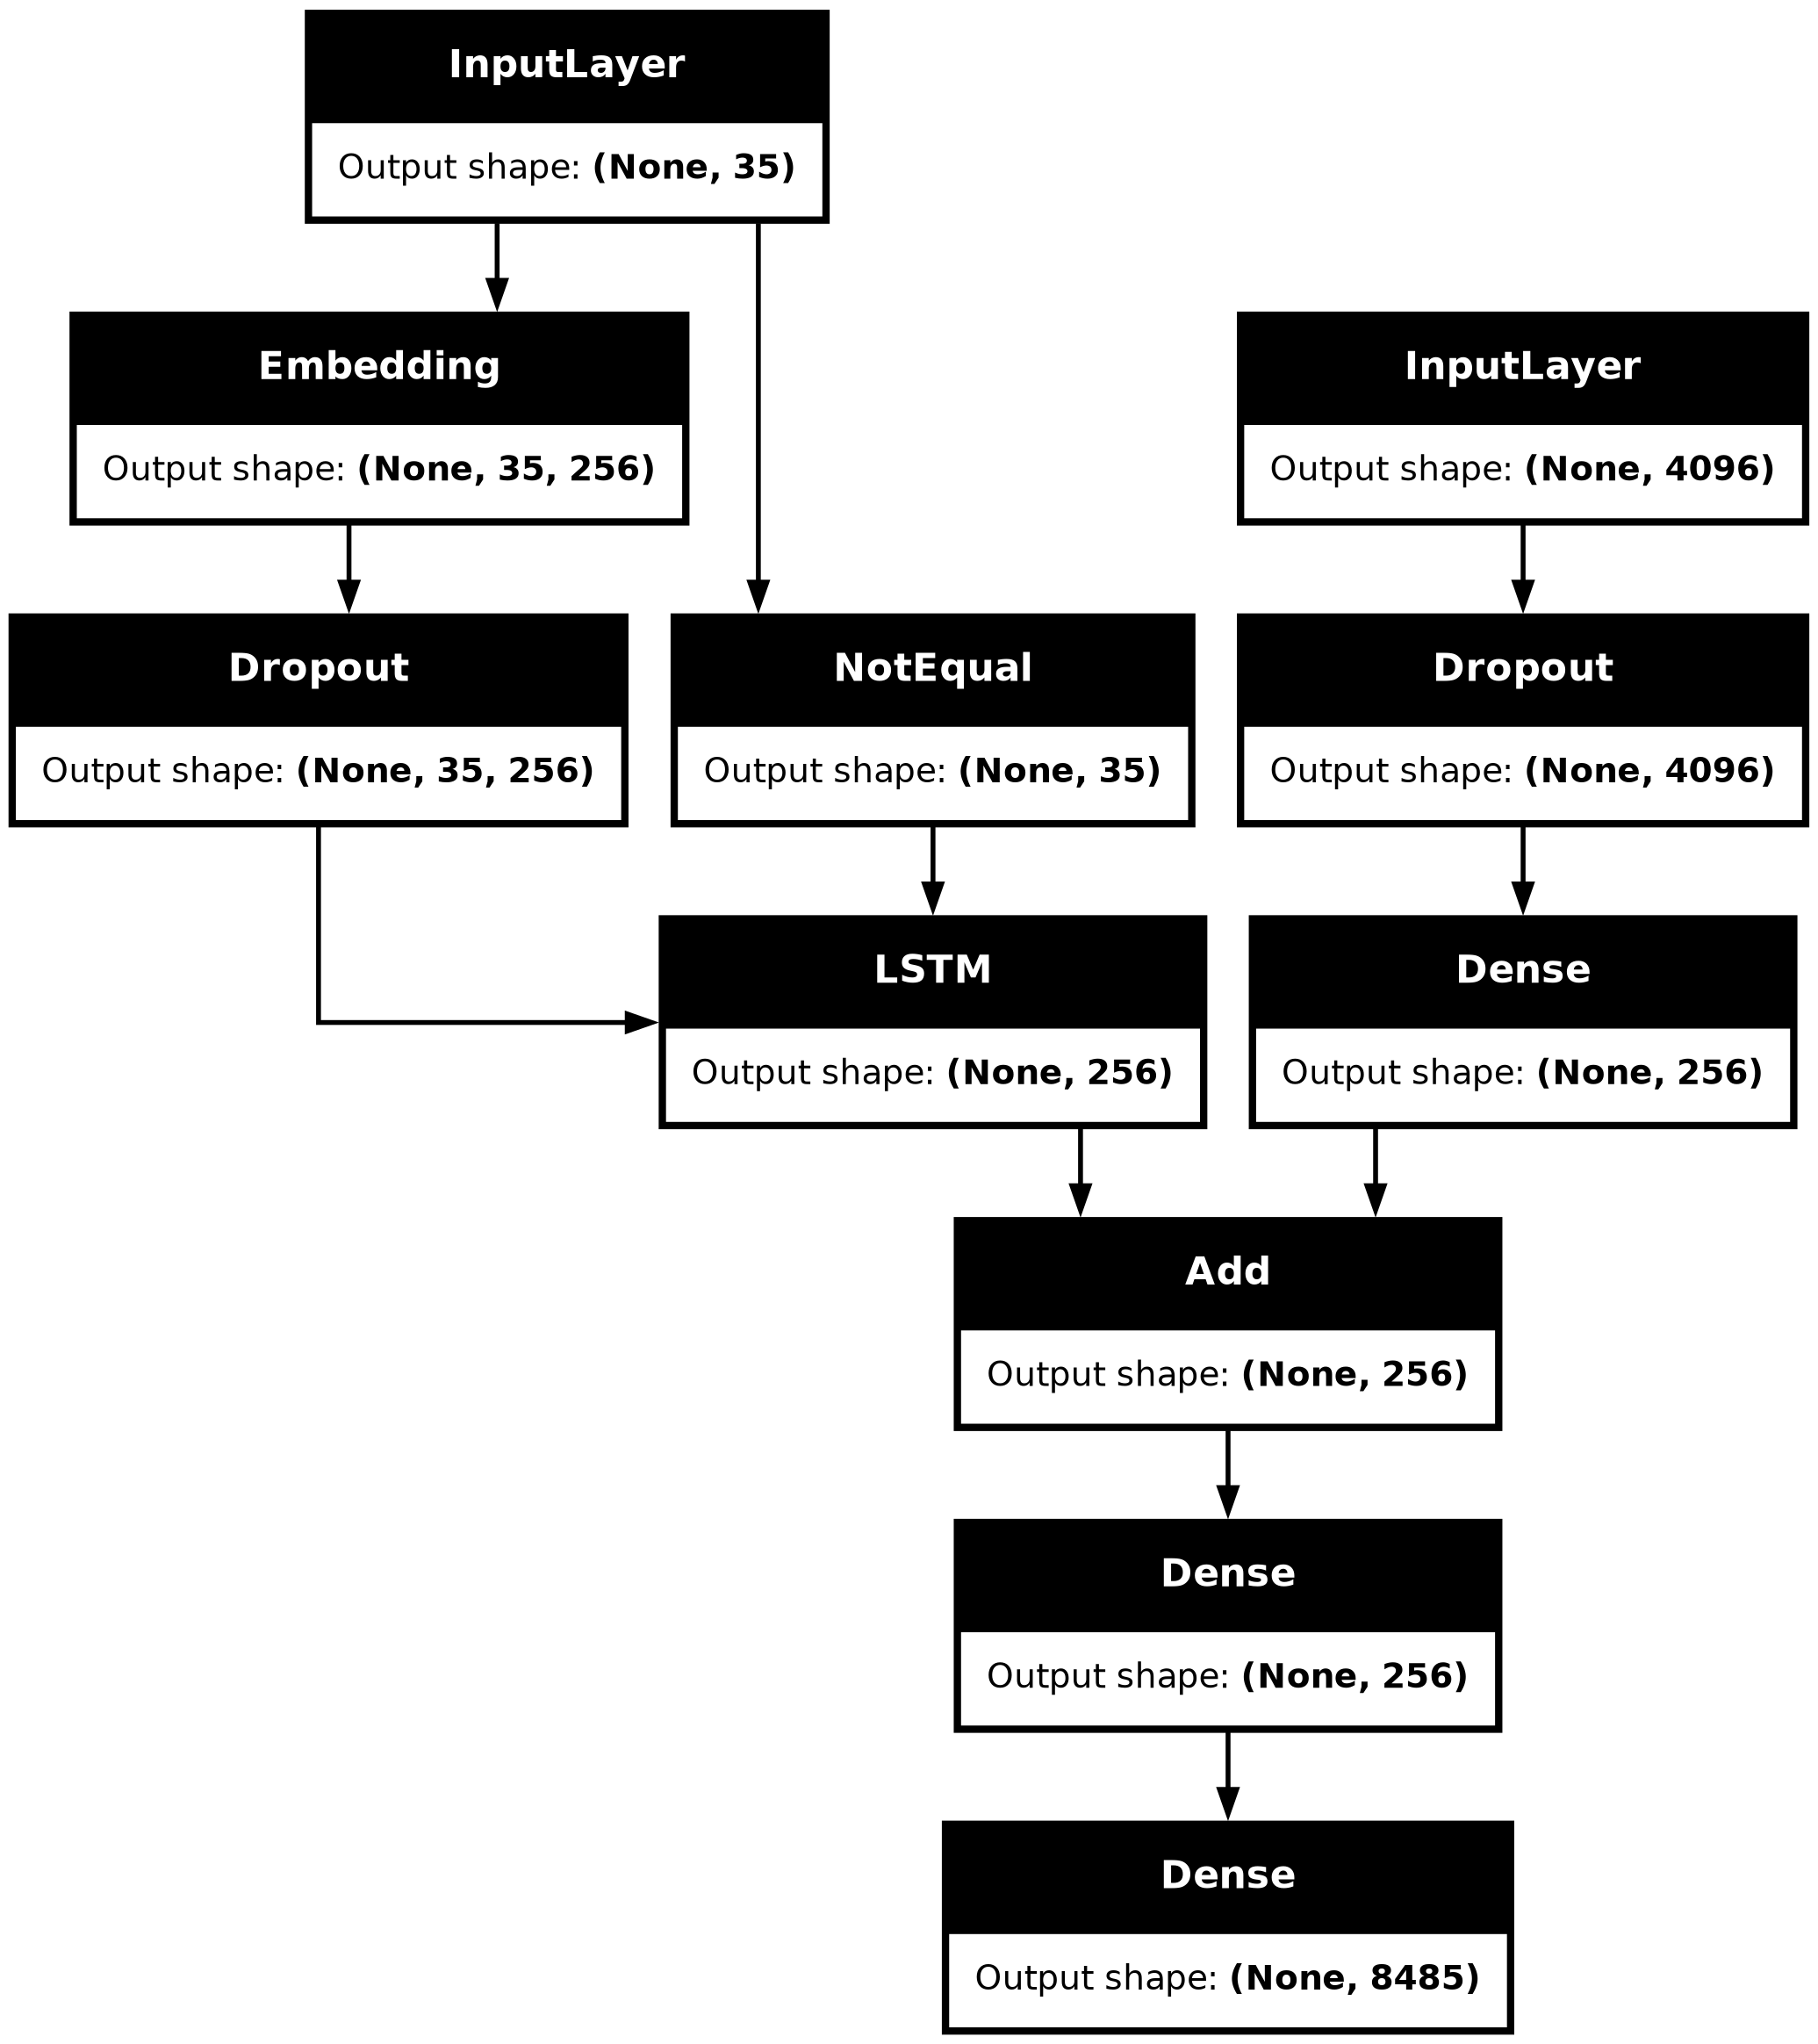

In [ ]:
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [ ]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 67s 272ms/step - loss: 5.7630
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - loss: 4.0778
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - loss: 3.6053
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 3.3197
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 3.1125
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.9572
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - loss: 2.8369
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.7469
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 2.6710
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 2.5364
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.4797
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - loss: 2.4239
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 2.3813
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 270ms/step - loss: 2.3374
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 2.3017
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 2.2720
227/227 ━━━━━━━━━━━━━━━━━━━━ 61s 268ms/step - loss: 2.23

In [ ]:
model.save(output_dir+'/best_model.h5')

In [ ]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = maps[key]
    ypreds= predict_caption(model, features[key], tokenizer, max_length)
    real_captions = [caption.split() for caption in captions]
    ypreds = ypreds.split()
    actual.append(real_captions)
    predicted.append(ypreds)
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.523654
BLEU-2: 0.301855


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join(data_dir, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq child playing on rope net endseq
startseq little girl climbing on red roping endseq
startseq little girl in pink climbs rope bridge at the park endseq
startseq small child grips onto the red ropes at the playground endseq
startseq the small child climbs on red ropes on playground endseq
--------------------Predicted--------------------
startseq child climbing off red bridge endseq


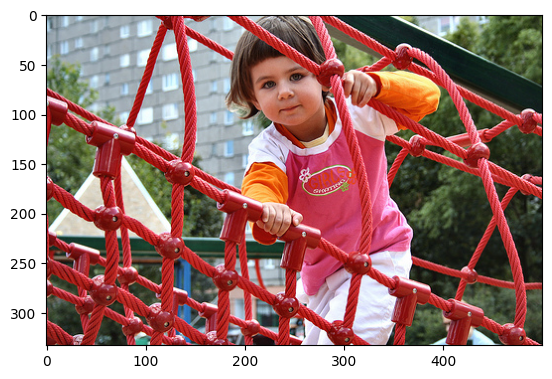

In [ ]:
generate_caption("1007320043_627395c3d8.jpg")

---------------------Actual---------------------
startseq man and woman pose for the camera while another man looks on endseq
startseq man is holding the hand of woman up to his mouth in front of some buildings while another man looks on endseq
startseq multiracial couple posing for picture endseq
startseq "asian man and blond woman holding hands outdoors man in background watches ." endseq
startseq guy in blue shirt biting hand of girl in black striped jacket while another guy watches endseq
--------------------Predicted--------------------
startseq two children are having each other in front of the other children endseq


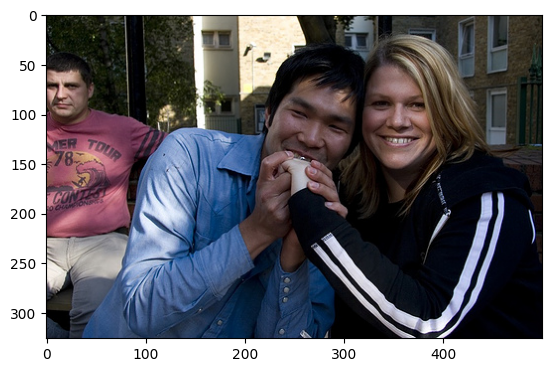

In [ ]:
generate_caption('1042590306_95dea0916c.jpg')